# Flight prices prediction

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sns
import os

In [166]:
os.listdir()

['flight prices.ipynb', 'flights.csv']

In [167]:
df = pd.read_csv("./flights.csv")

## Sort and clean data

### Check for NaN

In [168]:
df.isna().sum()

Airline           0
Source            0
Destination       0
Total_Stops       0
Price             0
Date              0
Month             0
Year              0
Dep_hours         0
Dep_min           0
Arrival_hours     0
Arrival_min       0
Duration_hours    0
Duration_min      0
dtype: int64

### Remove outliers

In [169]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

numerical_columns = ['Price', 'Dep_hours', 'Dep_min', 'Arrival_hours', 'Arrival_min', 'Duration_hours', 'Duration_min']
for column in numerical_columns:
    df = remove_outliers_iqr(df, column)


### Create route feature of source and destination

In [170]:
df["Route"] = df["Source"]+"-" + df["Destination"]

In [171]:
df = df.drop(["Source","Destination"],axis=1)

### Emerge duration hours and min 

In [172]:
df["Duration(min)"] = df["Duration_hours"] * 60 + df["Duration_min"]
df.drop(["Duration_hours", "Duration_min"], axis = 1, inplace = True)

### Remove years column
**it is always 2019**

In [173]:
df.drop(columns = ['Year'], inplace = True)

**Convert time of arrival and departure to category**

In [174]:
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 22:
        return 'evening'
    else:
        return 'night'

df['Dep_time'] = df['Dep_hours'].apply(time_of_day)
df['Arrival_time'] = df['Arrival_hours'].apply(time_of_day)

df.drop(["Dep_hours", "Dep_min","Arrival_hours", "Arrival_min"], axis = 1, inplace = True)

### Check for duplicates

In [175]:
df.duplicated().sum()

379

In [176]:
df.drop_duplicates(inplace=True)

In [177]:
df.duplicated().sum()

0

In [178]:
len(df)

10138

In [179]:
df.head(10)

,Airline,Total_Stops,Price,Date,Month,Route,Duration(min),Dep_time,Arrival_time
0,IndiGo,0,3897,24,3,Banglore-New Delhi,170,night,night
1,Air India,2,7662,1,5,Kolkata-Banglore,445,morning,afternoon
2,Jet Airways,2,13882,9,6,Delhi-Cochin,1140,morning,night
3,IndiGo,1,6218,12,5,Kolkata-Banglore,325,evening,night
4,IndiGo,1,13302,1,3,Banglore-New Delhi,285,afternoon,evening
5,SpiceJet,0,3873,24,6,Kolkata-Banglore,145,morning,morning
6,Jet Airways,1,11087,12,3,Banglore-New Delhi,930,evening,morning
7,Jet Airways,1,22270,1,3,Banglore-New Delhi,1265,morning,morning
8,Jet Airways,1,11087,12,3,Banglore-New Delhi,1530,morning,morning
9,Multiple carriers,1,8625,27,5,Delhi-Cochin,470,morning,evening


# Get valuable data from tables 

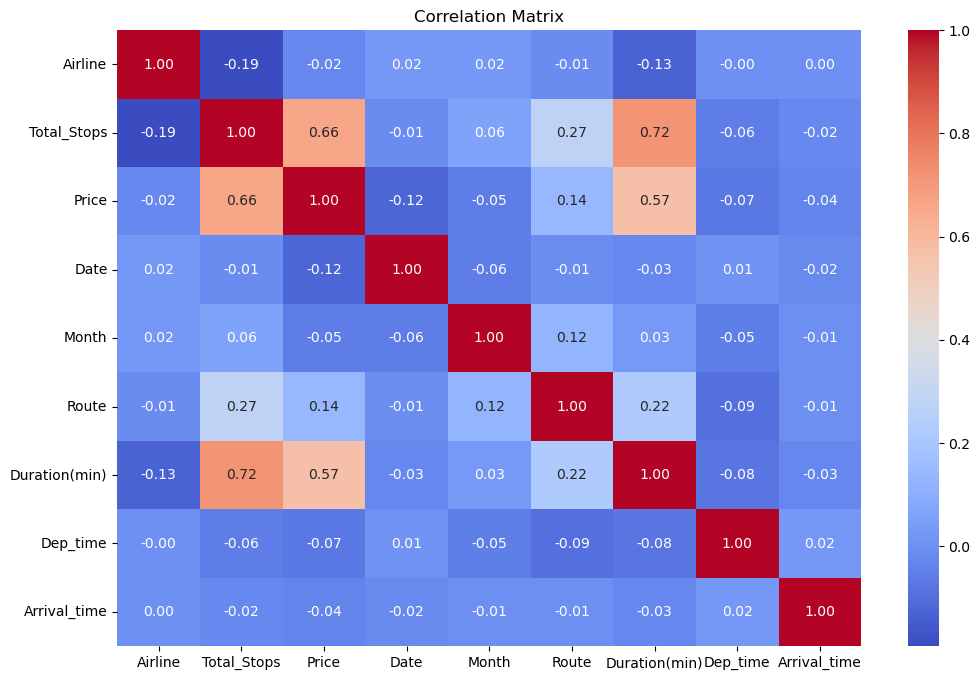

In [180]:
from sklearn.preprocessing import LabelEncoder

df_corr = df.copy()
categorical_features = df_corr.select_dtypes(include=['object']).columns
for feature in categorical_features:
    le = LabelEncoder()
    df_corr[feature] = le.fit_transform(df_corr[feature])

# Calculate the correlation matrix
correlation_matrix = df_corr.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show();

## set plots colors

In [181]:
cmap = plt.get_cmap("tab20")
colors = []
for step in np.linspace(0,1,12):
    colors.append(clr.rgb2hex(cmap(step)))

In [182]:
df.head(10)

,Airline,Total_Stops,Price,Date,Month,Route,Duration(min),Dep_time,Arrival_time
0,IndiGo,0,3897,24,3,Banglore-New Delhi,170,night,night
1,Air India,2,7662,1,5,Kolkata-Banglore,445,morning,afternoon
2,Jet Airways,2,13882,9,6,Delhi-Cochin,1140,morning,night
3,IndiGo,1,6218,12,5,Kolkata-Banglore,325,evening,night
4,IndiGo,1,13302,1,3,Banglore-New Delhi,285,afternoon,evening
5,SpiceJet,0,3873,24,6,Kolkata-Banglore,145,morning,morning
6,Jet Airways,1,11087,12,3,Banglore-New Delhi,930,evening,morning
7,Jet Airways,1,22270,1,3,Banglore-New Delhi,1265,morning,morning
8,Jet Airways,1,11087,12,3,Banglore-New Delhi,1530,morning,morning
9,Multiple carriers,1,8625,27,5,Delhi-Cochin,470,morning,evening


## plot some graphs

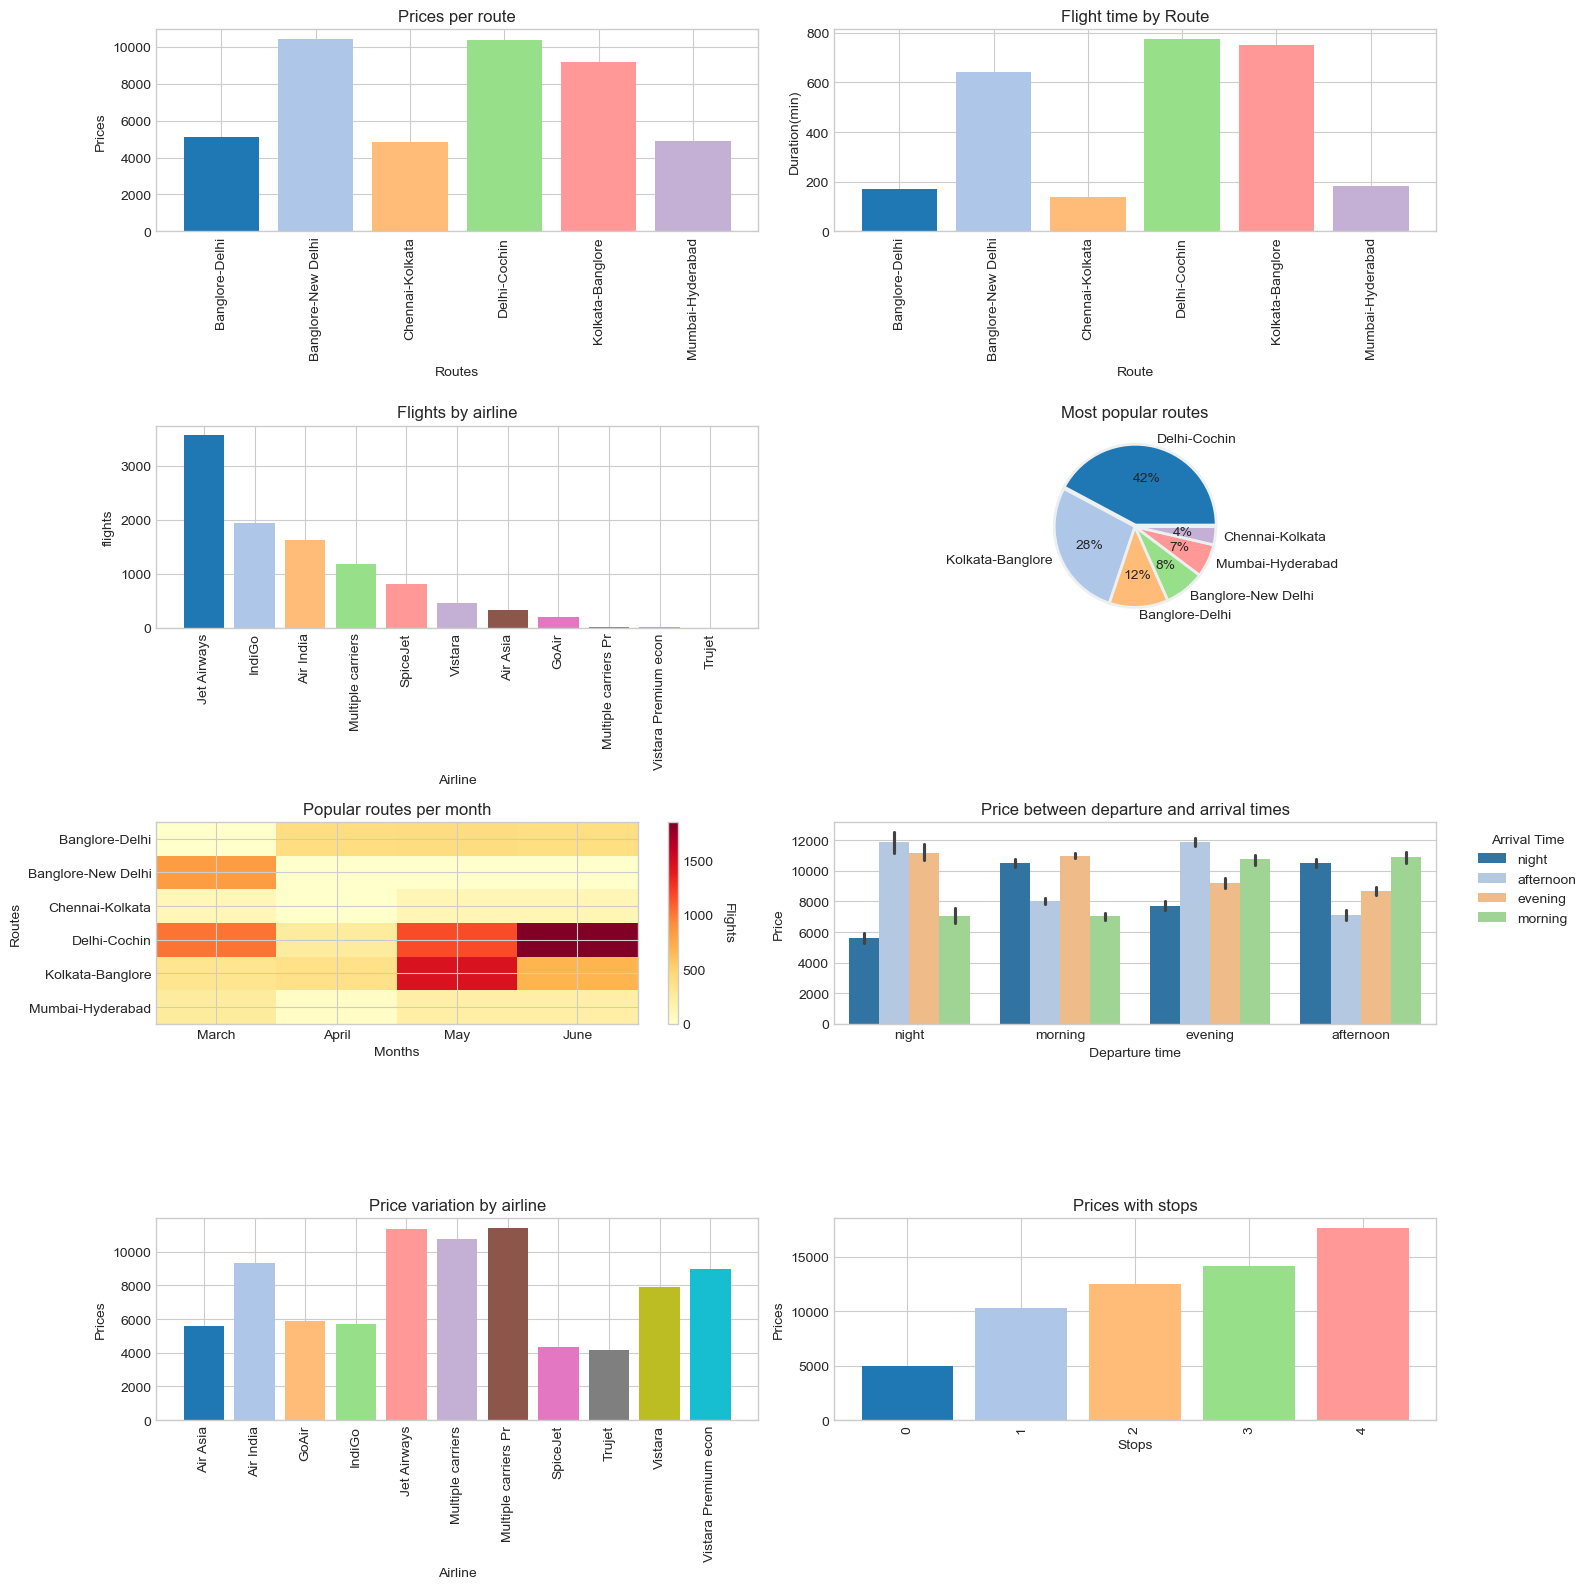

In [183]:
# Prices per airline
with plt.style.context("seaborn-v0_8-whitegrid"):
    airline_price = df.groupby("Airline")["Price"].mean()

    airline_ticks = [key[:20] for key in airline_price.keys()]

    fig,(
        (ax1,ax2),
        (ax3,ax4),
        (ax5,ax6),
        (ax7,ax8)
        )=plt.subplots(
        figsize = (16,16),
        nrows = 4,
        ncols = 2
    )

    # prices by routes
    price_route = df.groupby('Route')['Price'].mean()
    ax1.bar(
        price_route.keys(),
        price_route,
        color = colors
    )
    ax1.set_xticks(ticks = price_route.keys(),labels = price_route.keys(),rotation=90)
    ax1.set(
            title = "Prices per route",
            xlabel = "Routes",
            ylabel = "Prices"
        )
    # fligt durations per airline
    route_duration = df.groupby("Route")["Duration(min)"].mean().astype(int)
    ax2.bar(route_duration.keys(), 
            route_duration,
            color = colors
        )
    
    ax2.set(
        title = "Flight time by Route",
        xlabel = "Route",
        ylabel = "Duration(min)"
    )

    ax2.set_xticks(ticks= route_duration.keys(),labels = route_duration.keys(),rotation=90)

    #flights per airline
    flight_count = df["Airline"].value_counts()

    ax3.bar(flight_count.index,
            flight_count.values,
            color = colors
        )
    ax3.set(
        title = "Flights by airline",
        xlabel = "Airline",
        ylabel = "flights"
    )
    ax3.set_xticks(ticks = airline_price.keys(),labels = airline_ticks,rotation=90)

    # popular routes
    routes_count = df['Route'].value_counts()

    ax4.pie(
        routes_count.values,
        labels=routes_count.index,
        explode=[0.02,0,0,0,0,0],
        colors = colors,
        wedgeprops = {
            'edgecolor': '#ecf0f1',
            'linewidth':2
        },
        autopct='%1.0f%%',
        
    )
    ax4.set(
        title = "Most popular routes"
    )

    # Popular routes by month
    route_month_counts = df.groupby(['Route','Month']).size().reset_index(name='Flights').sort_values(by='Month')
    pivot_table = route_month_counts.pivot(index='Route', columns='Month', values='Flights').fillna(0)
    months = pd.to_datetime(route_month_counts['Month'],format="%m").dt.month_name()
    pivot_table = pivot_table.sort_index()
    cax = ax5.imshow(pivot_table, cmap='YlOrRd', aspect='auto')
    ax5.set_xticks(ticks=range(len(pivot_table.columns)), labels=months.unique())
    ax5.set_yticks(ticks=range(len(pivot_table.index)), labels=pivot_table.index)
    ax5.set(
        title = "Popular routes per month",
        xlabel = "Months",
        ylabel = "Routes"
    )
    cbar = fig.colorbar(cax, ax=ax5, orientation='vertical')
    cbar.set_label('Flights', rotation=270, labelpad=15)
  
    # Price between departure and arrival times
    sns.barplot(x='Dep_time', y='Price', hue='Arrival_time', data=df, palette=colors[:4],ax=ax6)
    ax6.set(
        title = "Price between departure and arrival times",
        xlabel = "Departure time",
        ylabel = "Price"
    )
    ax6.legend(title='Arrival Time', bbox_to_anchor=(1.05, 1), loc='upper left')

 
    ax7.bar(airline_price.keys(), 
                airline_price,
                color= colors)
    ax7.set(
        title = "Price variation by airline",
        xlabel = "Airline",
        ylabel = "Prices"
    )
    ax7.set_xticks(ticks = airline_price.keys(),labels=airline_ticks ,rotation=90)

    # Prices to stops
    price_stops = df.groupby('Total_Stops')['Price'].mean()
    ax8.bar(
        price_stops.keys(),
        price_stops,
        color = colors
    )
    ax8.set_xticks(ticks = price_stops.keys(),labels = price_stops.keys(),rotation=90)
    ax8.set(
            title = "Prices with stops",
            xlabel = "Stops",
            ylabel = "Prices"
        )
    fig.tight_layout();
    plt.show();

# Predicting flight prices

### preparing models

In [184]:
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

regression_models = {"Ridge": Ridge(),
                     "SVR_linear": SVR(),
                     "SVR_rbf": SVR(kernel="rbf"),
                     'LFR': LinearRegression(),
                     "RandomForestRegressor": RandomForestRegressor()}

# Create an empty dictionary for the regression results
regression_results = {}

categorical_features = ["Airline", "Total_Stops", 'Date', 'Month', 'Route', 'Dep_time', 'Arrival_time']
numeric_features = ['Duration(min)']


categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ]
)

X = df.drop('Price', axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Loop through the items in the regression_models dictionary
for model_name, model in regression_models.items():
    
    # Create a model Pipeline with a preprocessor step and model step
    model_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                      ("model", model)])
    
    # Fit the model Pipeline to the car sales training data
    print(f"Fitting {model_name}...")
    model_pipeline.fit(X_train, y_train)
    
    # Score the model Pipeline on the test data appending the model_name to the 
    # results dictionary
    print(f"Scoring {model_name}...")
    regression_results[model_name] = model_pipeline.score(X_test, y_test)

regression_results

Fitting Ridge...
Scoring Ridge...
Fitting SVR_linear...
Scoring SVR_linear...
Fitting SVR_rbf...
Scoring SVR_rbf...
Fitting LFR...
Scoring LFR...
Fitting RandomForestRegressor...
Scoring RandomForestRegressor...


{'Ridge': 0.648592774926557,
 'SVR_linear': 0.08227364369962009,
 'SVR_rbf': 0.08227364369962009,
 'LFR': 0.6482006376633552,
 'RandomForestRegressor': 0.7792801414017496}

In [185]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_regression_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs y_pred labels for regression.
    """
    mse = mean_squared_error(y_true, y_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_preds)
    r2 = r2_score(y_true, y_preds)
    
    metric_dict = {
        "MSE": round(mse, 2),
        "RMSE": round(rmse, 2),
        "MAE": round(mae, 2),
        "R2": round(r2, 2)
    }
    return metric_dict

**Highest score was for `RandomForestRegressor()`, let's predict with it**

In [186]:
model = RandomForestRegressor()
  # Create a model Pipeline with a preprocessor step and model step
model_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                    ("model", model)])

model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)
evaluate_regression_preds(y_pred,y_test)

{'MSE': 3496678.31, 'RMSE': 1869.94, 'MAE': 1256.06, 'R2': 0.75}

***R2 was a good starting result but the MSE and MAE were too high since the price is in dollar unit***

**convert price unit and retry**

In [187]:
# convert price to K unit
df['Price'] = df['Price'] / 1000

In [188]:
model = RandomForestRegressor()
  # Create a model Pipeline with a preprocessor step and model step
model_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                    ("model", model)])
X = df.drop('Price', axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)
evaluate_regression_preds(y_test,y_pred)

{'MSE': 3.5, 'RMSE': 1.87, 'MAE': 1.26, 'R2': 0.78}

***WAY BETTER***

### Model tuning

**Using GridSerachCV**

In [191]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__n_estimators': [100, 200,300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2,5,10],
    'model__min_samples_leaf': [1,2,4],
}
pipeline = Pipeline(
    steps=[("preprocessor", preprocessor),
    ("model", RandomForestRegressor())])
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           verbose=2,
                           n_jobs=-1) 

print("Fitting GridSearchCV...")

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

evaluate_regression_preds(y_test,y_pred)

Fitting GridSearchCV...
Fitting 5 folds for each of 108 candidates, totalling 540 fits


{'MSE': 2.96, 'RMSE': 1.72, 'MAE': 1.19, 'R2': 0.82}